### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [68]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [69]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):

    contexts = corpus[window_size:-window_size]
    targets = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                # skip target word itself
                continue
            cs.append(corpus[idx + t])
        targets.append(cs)

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([7, 0, 4, 1, 3, 5]),
 array([[2, 0],
        [7, 4],
        [0, 1],
        [4, 3],
        [1, 5],
        [3, 6]]))

In [70]:
# transform contexts and targets to one-hot encoding
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0]], dtype=int32),
 array([[[0, 0, 1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 1, 0, 0, 0]],
 
        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0]]], dtype=int32))

In [71]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size*2)]
        

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size*2)])
        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size*2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [72]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

 33%|███▎      | 329/1000 [00:00<00:00, 1464.11it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.1586910819777785
Epoch: 2, Iteration: 1/2, Loss: 4.158875059019992
Epoch: 3, Iteration: 1/2, Loss: 4.1587947430305245
Epoch: 4, Iteration: 1/2, Loss: 4.158706387507609
Epoch: 5, Iteration: 1/2, Loss: 4.158601974477122
Epoch: 6, Iteration: 1/2, Loss: 4.158583270857286
Epoch: 7, Iteration: 1/2, Loss: 4.158635420263096
Epoch: 8, Iteration: 1/2, Loss: 4.158495154919667
Epoch: 9, Iteration: 1/2, Loss: 4.158232185439199
Epoch: 10, Iteration: 1/2, Loss: 4.158522441042009
Epoch: 11, Iteration: 1/2, Loss: 4.158043633612113
Epoch: 12, Iteration: 1/2, Loss: 4.158148220384539
Epoch: 13, Iteration: 1/2, Loss: 4.157967814661137
Epoch: 14, Iteration: 1/2, Loss: 4.158081680875081
Epoch: 15, Iteration: 1/2, Loss: 4.157713913887963
Epoch: 16, Iteration: 1/2, Loss: 4.157624306041391
Epoch: 17, Iteration: 1/2, Loss: 4.157444196414943
Epoch: 18, Iteration: 1/2, Loss: 4.157418910248838
Epoch: 19, Iteration: 1/2, Loss: 4.157076235211435
Epoch: 20, Iteration: 1/2, Loss: 4.157

 62%|██████▎   | 625/1000 [00:00<00:00, 1464.02it/s]

Epoch: 350, Iteration: 1/2, Loss: 1.4128907265501447
Epoch: 351, Iteration: 1/2, Loss: 1.4103226363343566
Epoch: 352, Iteration: 1/2, Loss: 1.4123781092884844
Epoch: 353, Iteration: 1/2, Loss: 1.409805099223158
Epoch: 354, Iteration: 1/2, Loss: 1.4083160641075643
Epoch: 355, Iteration: 1/2, Loss: 1.4128425879585773
Epoch: 356, Iteration: 1/2, Loss: 1.408858081863087
Epoch: 357, Iteration: 1/2, Loss: 1.4109861907641226
Epoch: 358, Iteration: 1/2, Loss: 1.4099409768780422
Epoch: 359, Iteration: 1/2, Loss: 1.412227421492957
Epoch: 360, Iteration: 1/2, Loss: 1.4093408938518646
Epoch: 361, Iteration: 1/2, Loss: 1.409656055298003
Epoch: 362, Iteration: 1/2, Loss: 1.409081370111152
Epoch: 363, Iteration: 1/2, Loss: 1.410167123526059
Epoch: 364, Iteration: 1/2, Loss: 1.408843163099169
Epoch: 365, Iteration: 1/2, Loss: 1.4083037781686467
Epoch: 366, Iteration: 1/2, Loss: 1.408371925715771
Epoch: 367, Iteration: 1/2, Loss: 1.4092378013410274
Epoch: 368, Iteration: 1/2, Loss: 1.4094284199706404
E

100%|██████████| 1000/1000 [00:00<00:00, 1666.90it/s]

Epoch: 654, Iteration: 1/2, Loss: 1.3942576496718835
Epoch: 655, Iteration: 1/2, Loss: 1.394426481108199
Epoch: 656, Iteration: 1/2, Loss: 1.393640906614933
Epoch: 657, Iteration: 1/2, Loss: 1.395015255710276
Epoch: 658, Iteration: 1/2, Loss: 1.3939862918437202
Epoch: 659, Iteration: 1/2, Loss: 1.3946354290347847
Epoch: 660, Iteration: 1/2, Loss: 1.3945370183600487
Epoch: 661, Iteration: 1/2, Loss: 1.3940522307980654
Epoch: 662, Iteration: 1/2, Loss: 1.393534599323104
Epoch: 663, Iteration: 1/2, Loss: 1.3944796428857247
Epoch: 664, Iteration: 1/2, Loss: 1.3944225052702461
Epoch: 665, Iteration: 1/2, Loss: 1.3944171525139901
Epoch: 666, Iteration: 1/2, Loss: 1.3943730835176429
Epoch: 667, Iteration: 1/2, Loss: 1.3932417265384984
Epoch: 668, Iteration: 1/2, Loss: 1.3947064452945992
Epoch: 669, Iteration: 1/2, Loss: 1.3940411831772115
Epoch: 670, Iteration: 1/2, Loss: 1.3939753458287356
Epoch: 671, Iteration: 1/2, Loss: 1.3944675348214775
Epoch: 672, Iteration: 1/2, Loss: 1.39395775373370

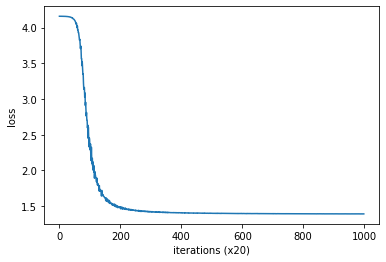

In [73]:
trainer.plot()

In [75]:
# check skip-gram results
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

studying [ 0.03509983  0.51529443 -0.9742502   1.727418    2.0924873 ]
language [ 0.14458317  1.736226    0.7649951   2.6704128  -0.12764466]
i [ 0.01455147 -0.00225844 -0.00152124 -0.00155948 -0.0171884 ]
processing [ 0.64390135 -1.6839404  -1.3443768  -0.9909441  -1.7128546 ]
natural [ 0.49661285 -2.2259881   0.7061572  -2.037493    0.51091766]
now [-0.49245292  0.77452797  0.9208236   0.89182234 -2.5126684 ]
. [ 0.00443482  0.00116071 -0.00473972  0.01033234  0.00074891]
am [-0.550826    0.53903264  0.5082179  -2.0508063   1.8738655 ]
